# 4.11. Regresja wielomianowa

Pewnym rozszerzeniem regresji liniowej jest regresja wielomianowa. Na jej potrzeby określamy stopień wielomianu, jakim będziemy chcieli przybliżyć modelowaną funkcję, a parametry dobierane są w taki sam sposób jak w przypadku regresji liniowej. Zamiast zmieniać funkcję błędu, dokonujemy tego poszerzenia w sposób niejawny, dołączając kwadraty oraz iloczyny oryginalnych zmiennych do przestrzeni wejściowej.

Powróćmy do przykładu z poprzedniego rozdziału, gdzie regresja liniowa nie poradziła sobie zbyt dobrze.

In [1]:
import pandas as pd
import numpy as np

In [2]:
np.random.seed(2020)
x = np.linspace(0, 10, 12)
xy_df = pd.DataFrame({
    "x": x,
    "y": x ** 2 - 7 * x + 2 * np.random.normal(size=12)
})
xy_df.sample(n=5)

,x,y
0,0.000000,-3.537691
3,2.727273,-12.955753
10,9.090909,17.405597
11,10.000000,32.624070
8,7.272727,2.803697


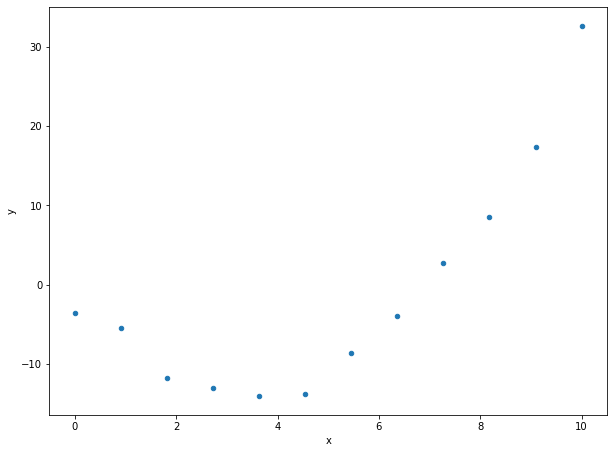

In [3]:
xy_df.plot.scatter(x="x", y="y", 
                   figsize=(10.0, 7.5))

Przeprowadzimy poszerzenie naszego zbioru danych ręcznie, a następnie nauczymy model regresji liniowej.

In [4]:
xy_df["x2"] = xy_df["x"] ** 2
xy_df.sample(n=5)

,x,y,x2
3,2.727273,-12.955753,7.438017
1,0.909091,-5.386086,0.826446
0,0.000000,-3.537691,0.000000
2,1.818182,-11.682747,3.305785
8,7.272727,2.803697,52.892562


In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
import matplotlib.pyplot as plt

In [7]:
def draw_line(a, b, x_min=-5, x_max=5, 
              c=(.75, .1, .1, .25)):
    x = np.linspace(x_min, x_max, 1000)
    y = a * x + b
    plt.plot(x, y, "-r", c=c)

In [8]:
X = xy_df.drop("y", axis="columns")

In [9]:
lr = LinearRegression()
lr.fit(X, xy_df["y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
lr.coef_, lr.intercept_

(array([-6.87839988,  1.01806729]), -2.119498165130876)

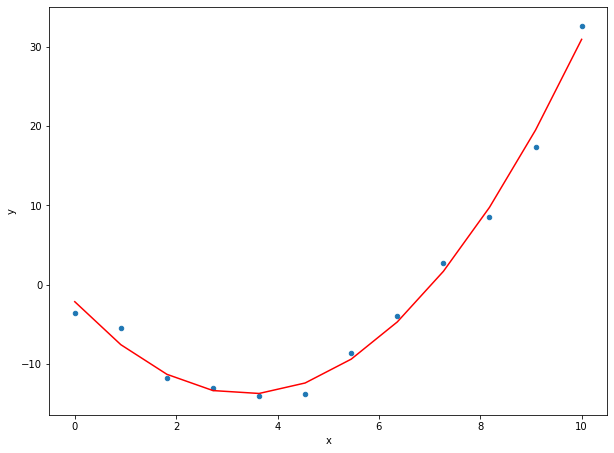

In [11]:
xy_df.plot.scatter(x="x", y="y", 
                   figsize=(10.0, 7.5))
plt.plot(X["x"], lr.predict(X), "-r")

## Uogólnione podejście w scikit-learn

Oczywiście poszerzenie zbioru danych w sposób ręczny jest możliwe, a czasem nawet wskazane. Jednak nie ma sensu robić tego manualnie poza momentami, gdy wynika to z naszej wiedzy eksperckiej. Na całe szczęście scikit-learn dostarcza zaimplementowany mechanizm wyliczający kombinacje wielomianowe naszych cech, aż do określonego stopnia, a także iloczyny potęg poszczególnych cech.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [13]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("polynomial_features", PolynomialFeatures(degree=15)),
    ("regressor", LinearRegression()),
])

In [14]:
pipeline.fit(xy_df[["x"]], xy_df["y"])

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial_features',
                 PolynomialFeatures(degree=15, include_bias=True,
                                    interaction_only=False, order='C')),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [15]:
pipeline.steps[2][1].coef_

array([-1.27400313e-11,  1.89234068e+01,  1.29010612e+01, -5.60617764e+01,
        5.05398373e-01,  9.49062515e+01, -3.02681251e+00, -5.03217955e+00,
       -2.54989729e+00, -5.19510055e+01,  4.87638405e-02, -2.09113225e+01,
        2.63897848e+00,  4.09874721e+01, -8.33197736e-01, -1.03062217e+01])

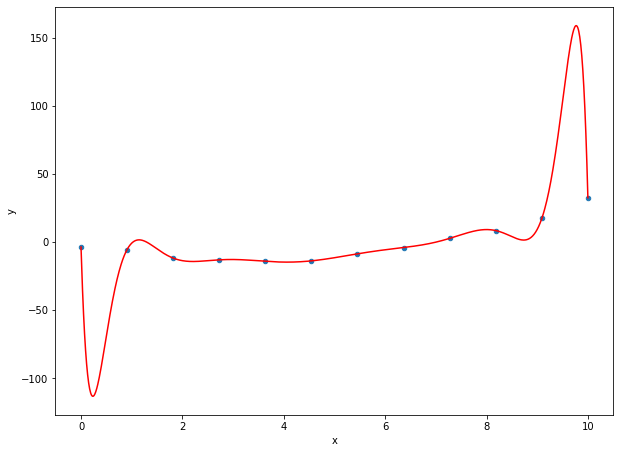

In [16]:
xy_df.plot.scatter(x="x", y="y", 
                   figsize=(10.0, 7.5))
x = np.linspace(0, 10, 1000)
plt.plot(x, pipeline.predict(x.reshape(-1, 1)), "-r")

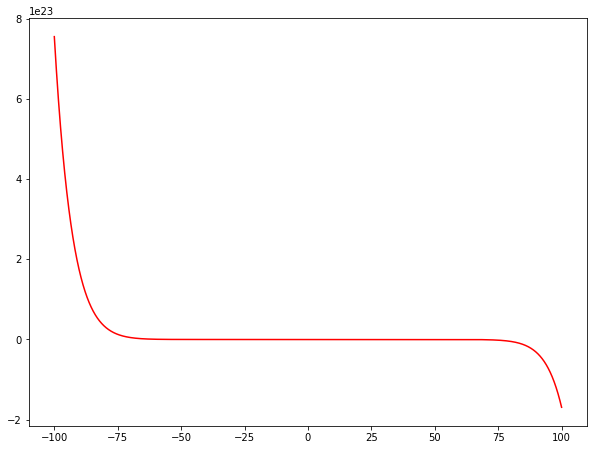

In [17]:
plt.figure(figsize=(10.0, 7.5))
x = np.linspace(-100, 100, 10000)
plt.plot(x, pipeline.predict(x.reshape(-1, 1)), "-r")

Trochę zbyt optymistycznie założyliśmy, że możemy ustalić sobie dowolnie wysoki stopień wielomianu, a system sam rozpozna jakich wyrazów użyć. Stało się coś, czego musimy unikać - model dopasował się bardzo mocno do danych treningowych i raczej nie rozpozna za dobrze nowych przykładów. Spróbujemy skorzystać z regularyzacji Lasso, aby ograniczyć wymiarowość zbioru.

In [18]:
from sklearn.linear_model import Lasso

In [19]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("polynomial_features", PolynomialFeatures(degree=15)),
    ("regressor", Lasso(alpha=10.0)),
])
pipeline.fit(xy_df[["x"]], xy_df["y"])
pipeline.steps[2][1].coef_

C:\Users\lukaw\anaconda3\envs\intro-to-ml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1055982829609547, tolerance: 0.2253682543229436
  positive)


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.18925292,  0.4165586 ,  0.        ,  0.        , -0.        ,
       -0.04759072])

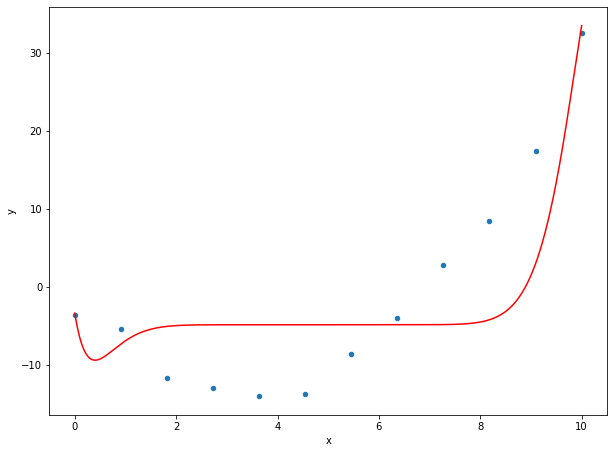

In [20]:
xy_df.plot.scatter(x="x", y="y", 
                   figsize=(10.0, 7.5))
x = np.linspace(0, 10, 1000)
plt.plot(x, pipeline.predict(x.reshape(-1, 1)), "-r")

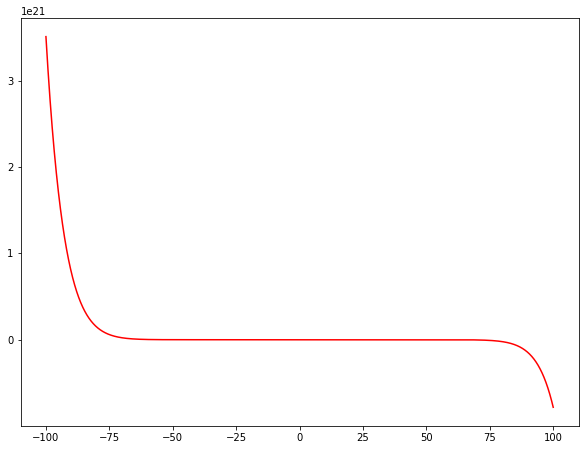

In [21]:
plt.figure(figsize=(10.0, 7.5))
x = np.linspace(-100, 100, 10000)
plt.plot(x, pipeline.predict(x.reshape(-1, 1)), "-r")

## Dobór optymalnego stopnia wielomianu

Zdecydowanie sama regularyzacja nie załatwi problemu doboru optymalnej konfiguracji modelu. Musimy ciągle zwracać uwagę na zdolności modelu do generalizacji, czyli wielkość błędu dla zbioru testowego.

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
cv = GridSearchCV(estimator=pipeline, param_grid={
    "polynomial_features__degree": range(1, 15),
    "regressor__alpha": np.linspace(0.5, 100.0, 10),
})

C:\Users\lukaw\anaconda3\envs\intro-to-ml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2854488880428576, tolerance: 0.16254698014326596
  positive)
C:\Users\lukaw\anaconda3\envs\intro-to-ml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.930471351754939, tolerance: 0.21296817302742263
  positive)
C:\Users\lukaw\anaconda3\envs\intro-to-ml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2841350466278314, tolerance: 0.16254698014326596
  positive)
C:\Users\lukaw\anaconda3\envs\intro-to-ml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did 

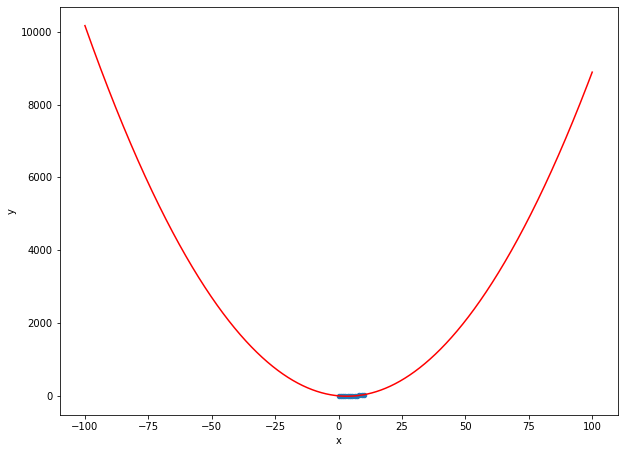

In [24]:
cv.fit(xy_df[["x"]], xy_df["y"])
xy_df.plot.scatter(x="x", y="y", 
                   figsize=(10.0, 7.5))
plt.plot(x, cv.predict(x.reshape(-1, 1)), "-r")

In [25]:
cv.best_estimator_.steps[2][1].coef_

array([0.        , 9.86329097, 9.38802746])

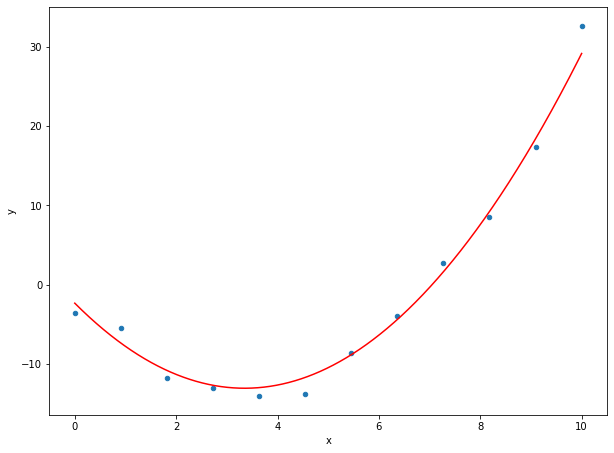

In [26]:
x = np.linspace(0, 10, 10000)
xy_df.plot.scatter(x="x", y="y", 
                   figsize=(10.0, 7.5))
plt.plot(x, cv.predict(x.reshape(-1, 1)), "-r")